In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!/opt/bin/nvidia-smi
!nvcc --version

# HRNet with Semtorch

## Libs setup and imports

In [ ]:
%pip install fastai==2.4.1
%pip install lapixdl==0.8.11
%pip install -U albumentations
%pip install SemTorch
%pip install opencv-python-headless==4.1.2.30

In [ ]:
import random
from pathlib import Path

import albumentations as A
import cv2
import imgaug
import numpy as np
import torch
from fastai.vision.all import (
    AddMaskCodes,
    Counter,
    CrossEntropyLossFlat,
    Datasets,
    FuncSplitter,
    Image,
    IntToFloatTensor,
    ItemTransform,
    Metric,
    PILImage,
    PILMask,
    SaveModelCallback,
    ShowGraphCallback,
    ToTensor,
    Transform,
    flatten_check,
    foreground_acc,
    get_image_files,
    is_listy,
    params,
)
from lapixdl.evaluation.model import Result
from lapixdl.evaluation.visualize import show_segmentations
from semtorch import get_segmentation_learner

# Fix seed
random.seed(81615)
imgaug.seed(81615)

## Utils

In [ ]:
def read_mask_and_simplify_normal_nuclei(mask_path: Path):
    mask_arr = np.array(PILMask.create(mask_path))
    # em_divisao || reacional = saudavel
    mask_arr[(mask_arr == 5) | (mask_arr == 7)] = 2
    return PILMask.create(mask_arr)

In [ ]:
# Fastai Transformers


class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0  # Train only
    order = 2  # After resize

    def __init__(self, aug):
        self.aug = aug

    def encodes(self, x):
        img, mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])


class ImageResizer(Transform):
    order = 1
    "Resize image to `size` using `resample`"

    def __init__(self, size, resample=Image.NEAREST):
        if not is_listy(size):
            size = (size, size)
        self.size, self.resample = (size[1], size[0]), resample

    def encodes(self, o: PILImage):
        return o.resize(size=self.size, resample=self.resample)

In [ ]:
# Validation metrics


class SSMetricBase(Metric):
    def __init__(self, axis=1):
        self.axis = axis

    def reset(self):
        self.intersection = {}
        self.total_area = {}

    def accumulate(self, learn):
        pred, targ = flatten_check(learn.pred.argmax(dim=self.axis), learn.y)
        for c in range(learn.pred.shape[self.axis]):
            # Get the prediction and target binary mask for `c` category
            p = torch.where(pred == c, 1, 0)
            t = torch.where(targ == c, 1, 0)

            # Compute the interpolation and total area between GT and prediction data
            # * and + is logical (* is and, + is or) operator between torch matrix

            intersection_ = (p * t).float().sum().item()
            total_area_ = (p + t).float().sum().item()
            if c in self.intersection:
                self.intersection[c] += intersection_
                self.total_area[c] += total_area_
            else:
                self.intersection[c] = intersection_
                self.total_area[c] = total_area_


class mDSC(SSMetricBase):
    "Mean of Dice Similarity Coefficients (DSC) metric for multicategory target in segmentation"

    @property
    def value(self):
        def DSC(intersection, total_area):
            return 2.0 * intersection / total_area if total_area > 0 else np.nan

        return np.nanmean(
            [DSC(self.intersection[c], self.total_area[c]) for c in self.intersection]
        )


class mIoU(SSMetricBase):
    "Mean of Intersection over Union (IoU) metric for multicategory target in segmentation"

    @property
    def value(self):
        def IoU(intersection, total_area):
            union = total_area - intersection
            return intersection / union if union > 0 else np.nan

        return np.nanmean(
            [IoU(self.intersection[c], self.total_area[c]) for c in self.intersection]
        )


def acc_metric(ipt, target):
    return foreground_acc(ipt, target, bkg_idx=0)

## Paths and metadata configuration

Fill the paths accordingly to the structure of the dataset and the output directories.

To load the data from google drive (on google colab), use:

```python
from google.colab import drive

drive.mount("/content/gdrive")
```

In [ ]:
path_dataset = Path("[dataset root folder]")
path_lbl = (
    path_dataset / "multiclass_masks"
)  # Masks folder. All masks must be in the root folder.
path_img = (
    path_dataset / "images"
)  # Images root folder. The images must be inside the train, val and test folders.
path_output = Path("[output root folder]")
path_models = path_output / "Models/segmentation/multiclass/models_hrnet_18_v41"

path_test_img = path_img / "test"

test_image_files = get_image_files(path_test_img)

In [ ]:
# Creates a list with all the images filenames
fnames = get_image_files(path_img, folders=["train", "val"])


# Util to get mask path by image path
def get_mask(path):
    return path_lbl / f"{path.stem}{path.suffix}"


# Image size
mask = PILMask.create(get_mask(fnames[1]))
src_size = np.array(mask.shape)
src_size

array([1200, 1600])

In [ ]:
# Defines the names of the dataset classes. It can be defined using an array instead of loading it from a file.
codes = np.loadtxt(path_dataset / "codes_multiclasse.txt", dtype=str)
codes[0] = "background"
codes

array(['background', 'anormal', 'saudavel', 'fora_de_foco', 'sanguinea',
       'em_divisao', 'nao_definida', 'reacional'], dtype='<U14')

## Data Analisys

Show random image GT using the LapixDL library

In [ ]:
# Shows the mask count
masks_fnames = get_image_files(path_lbl)
len(masks_fnames)

/content/gdrive/Shareddrives/Citologia Computacional/Datasets/UFSC OCPap: Papanicolaou Stained Oral Cytology Dataset/current/images/train/2019_07_10__14_48__0045_b0s0c0x170085-1600y63882-1200m8909.tiff


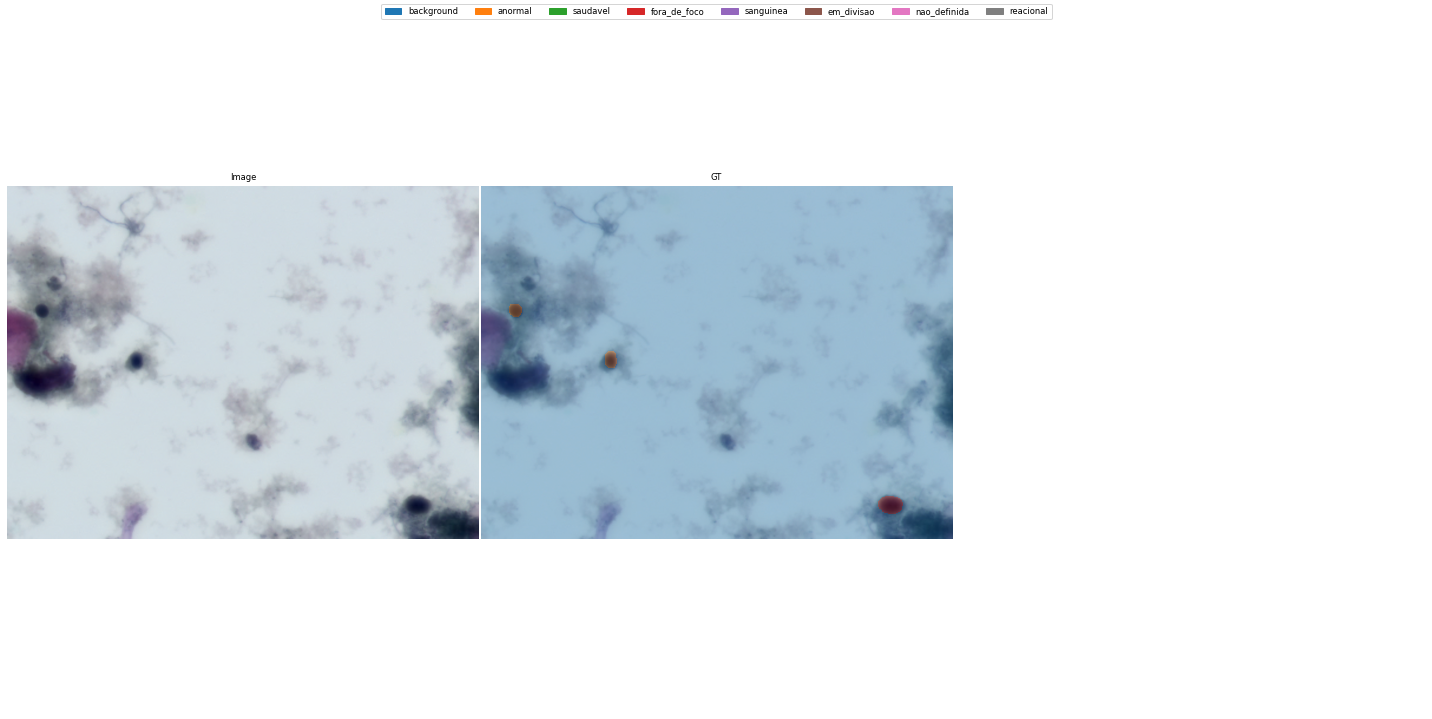

In [ ]:
img_f = fnames[random.randint(0, len(fnames) - 1)]
print(img_f)

img = PILImage.create(img_f)
mask = read_mask_and_simplify_normal_nuclei(get_mask(img_f))

fig, axes = show_segmentations([Result(np.array(img), np.array(mask))], codes)

## Train pipeline setup

### Architecture Definition

The complete list of supported models is available in the Semtorch repo: <https://github.com/WaterKnight1998/SemTorch#supported-configs>

In [ ]:
architecture = "hrnet"
backbone = "hrnet_w18"

### Pipeline

In [ ]:
# Augmentations setup


def zoom_augmentation(img_shape):
    return A.Compose(
        [
            A.RandomScale(scale_limit=(0, 0.1), p=0.75),
            A.CenterCrop(img_shape[0], img_shape[1]),
        ]
    )


def augmentations(img_shape):
    return A.Compose(
        [
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Rotate((-90, 90), p=0.75, interpolation=cv2.INTER_NEAREST),
            zoom_augmentation(img_shape),
            A.RandomBrightnessContrast(0.1, 0.1, p=0.75),
            A.Affine(p=0.75, shear=0.2),
        ]
    )

In [ ]:
tfms = [
    [PILImage.create],
    [get_mask, read_mask_and_simplify_normal_nuclei, AddMaskCodes(codes)],
]
folder_split = FuncSplitter(lambda fname: Path(fname).parent.name == "val")
src = Datasets(fnames, tfms, splits=folder_split(fnames))

## Training

In [ ]:
miou = mIoU()
mdsc = mDSC()
metrics = [acc_metric, mdsc, miou]

In [ ]:
# Splitter that tells the learner wich parts of the network it should freeze
def hrnet_splitter(model):
    return [params(model.backbone), params(model.head)]


def get_learner(data, load_model=None, unfreeze: bool = False):
    """Creates and setups the learner for each step of the training approach.

    Args:
        data: Dataloader.
        load_model (str): Path to the model to be loaded.
        unfreeze (bool): Indicates if the model should be unfreezed. Defaults to False.
    """

    learn = get_segmentation_learner(
        dls=data,
        number_classes=len(codes),
        segmentation_type="Semantic Segmentation",
        architecture_name=architecture,
        backbone_name=backbone,
        metrics=metrics,
        splitter=hrnet_splitter,
        pretrained=True,
        loss_func=CrossEntropyLossFlat(axis=1),
    ).to_fp16()

    learn.path = path_models
    if load_model is not None:
        learn.load(load_model, with_opt=True)
    if unfreeze:
        learn.unfreeze()
    return learn

### 1/4 Size

Training the model using 1/4 the size of the images

In [ ]:
size = src_size // 4
bs = 32  # Adjust the batch size accordingly to the GPU VRAM capacity

transforms = [
    ImageResizer((size[0], size[1])),
    ToTensor(),
    IntToFloatTensor(),
    SegmentationAlbumentationsTransform(augmentations(size)),
]

print(size)

[300 400]


In [ ]:
# Creates the dataloader
data = src.dataloaders(bs=bs, after_item=transforms)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


SuggestedLRs(valley=0.0012022644514217973)

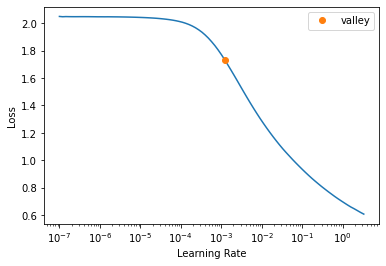

In [ ]:
# Runs the learning rate finder
get_learner(data).lr_find()

100%|██████████| 83749/83749 [00:07<00:00, 11172.95KB/s]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with m_dsc value: 0.40217360010178566.


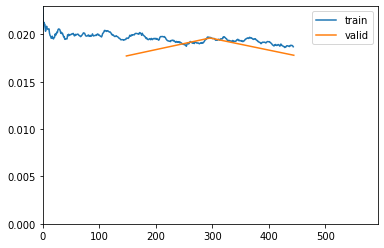

Better model found at epoch 1 with m_dsc value: 0.41172709553684333.
Better model found at epoch 2 with m_dsc value: 0.44704520810653275.


In [ ]:
lr = slice(1e-3)  # Choose accordingly to the learning rate finder results
wd = 1e-3  # Weight decay

learn = get_learner(data)
callbacks = [
    SaveModelCallback(
        monitor="m_dsc", fname="best_model_300x400_stg1", with_opt=True
    ),  # Saves the best model as `fname` in `learn.path` considering the metric defined in `monitor`.
    ShowGraphCallback(),  # Shows the train/validation graph
]

# Train
learn.fit_one_cycle(15, lr_max=lr, wd=wd, cbs=callbacks)

100%|██████████| 83749/83749 [00:07<00:00, 11249.59KB/s]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


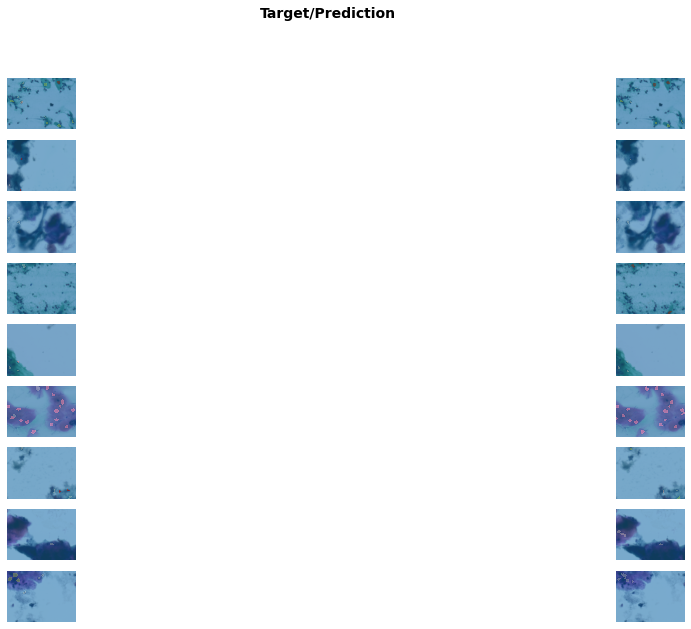

In [ ]:
get_learner(data, "best_model_300x400_stg1").show_results(
    figsize=(20, 10)
)  # Shows example results of the trained model

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


SuggestedLRs(valley=9.120108734350652e-05)

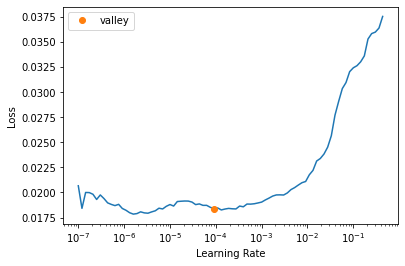

In [ ]:
# Load, unfreeze and lr finder for finetunning
get_learner(data, "best_model_300x400_stg1", True).lr_find()

100%|██████████| 83749/83749 [00:06<00:00, 12384.28KB/s]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with m_dsc value: 0.44752207423613316.


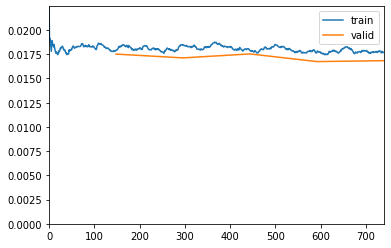

Better model found at epoch 1 with m_dsc value: 0.44906699520777216.
Better model found at epoch 2 with m_dsc value: 0.45012294157900357.
Better model found at epoch 3 with m_dsc value: 0.45723603479745495.


In [ ]:
lr = slice(1e-5, 1e-3)
wd = 1e-3

learn = get_learner(data, "best_model_300x400_stg1", True)
callbacks = [
    SaveModelCallback(monitor="m_dsc", fname="best_model_300x400_stg2", with_opt=True),
    ShowGraphCallback(),
]

# Finetune
learn.fit_one_cycle(15, lr_max=lr, wd=wd, cbs=callbacks)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


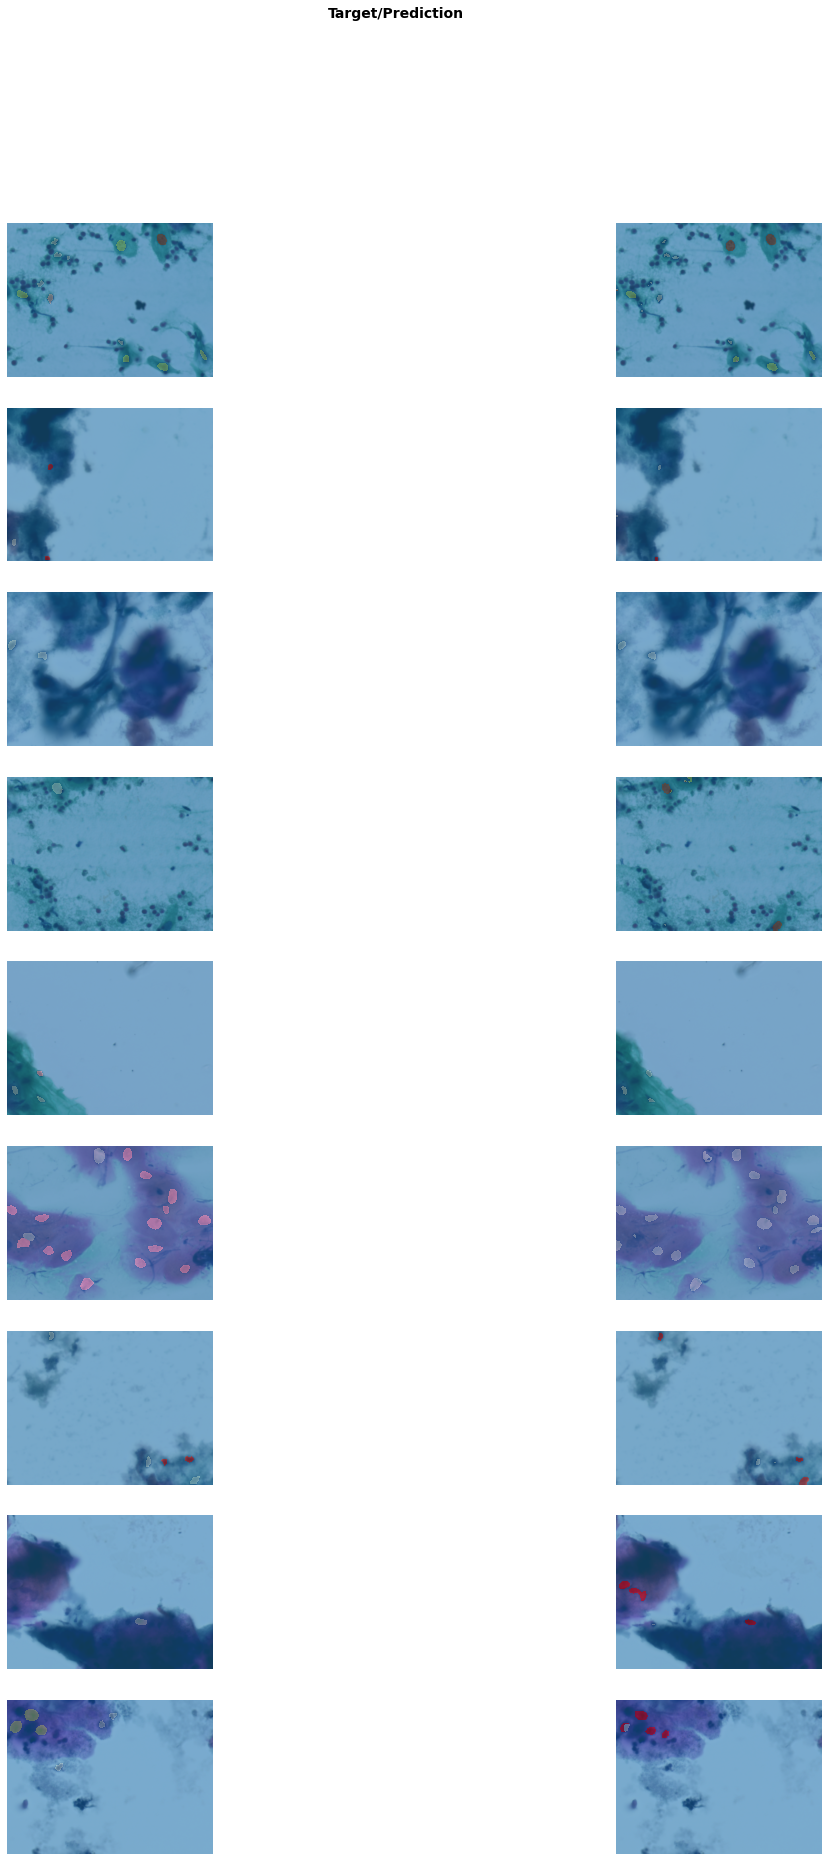

In [ ]:
get_learner(data, "best_model_300x400_stg2").show_results(
    figsize=(20, 30)
)  # Shows results of the finetunned model

### 1/2 Size

Training the model using 1/2 the size of the images. All the steps are identical to the 1/4 size training.

In [ ]:
size = src_size // 2
bs = 16  # Adjust the batch size accordingly to the GPU VRAM capacity

transforms = [
    ImageResizer((size[0], size[1])),
    ToTensor(),
    IntToFloatTensor(),
    SegmentationAlbumentationsTransform(augmentations(size)),
]
print(size)

[600 800]


In [ ]:
data = src.dataloaders(bs=bs, after_item=transforms)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


SuggestedLRs(valley=7.585775892948732e-05)

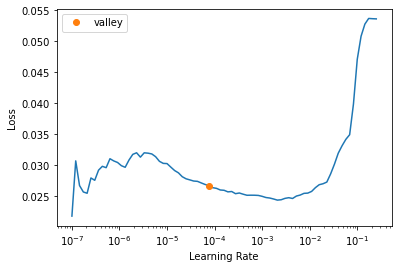

In [ ]:
get_learner(data, "best_model_300x400_stg2").lr_find()

100%|██████████| 83749/83749 [00:03<00:00, 25012.02KB/s]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with m_dsc value: 0.46534188469419985.


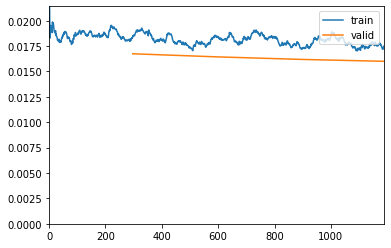

Better model found at epoch 1 with m_dsc value: 0.4779997582986402.
Better model found at epoch 2 with m_dsc value: 0.48055711441368504.


In [ ]:
lr = slice(1e-4)
wd = 1e-3

learn = get_learner(data, "best_model_300x400_stg2")
callbacks = [
    SaveModelCallback(monitor="m_dsc", fname="best_model_600x800_stg1", with_opt=True),
    ShowGraphCallback(),
]

learn.fit_one_cycle(15, lr_max=lr, wd=wd, cbs=callbacks)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


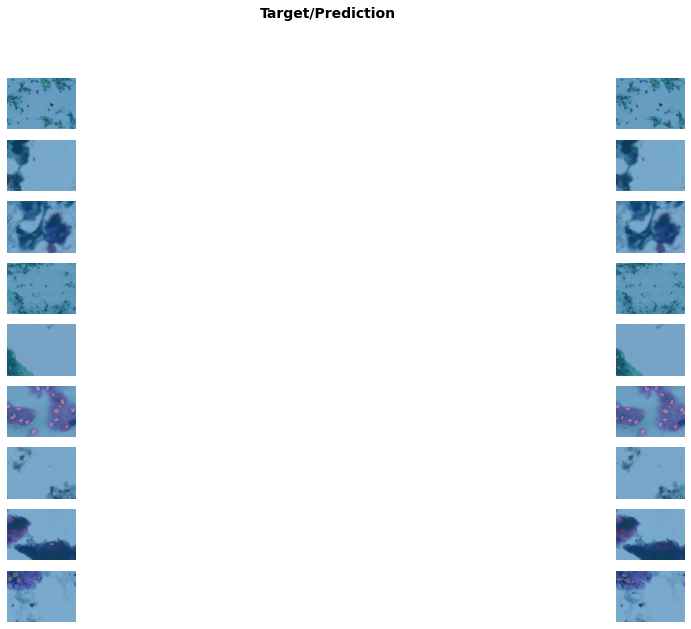

In [ ]:
get_learner(data, "best_model_600x800_stg1").show_results(figsize=(20, 10))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


SuggestedLRs(valley=0.00013182566908653826)

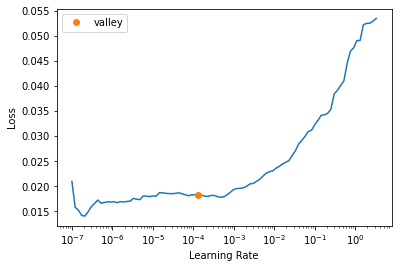

In [ ]:
get_learner(data, "best_model_600x800_stg1", True).lr_find()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with m_dsc value: 0.475744341934166.


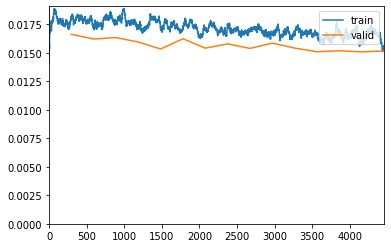

Better model found at epoch 2 with m_dsc value: 0.48174740581878456.
Better model found at epoch 6 with m_dsc value: 0.48742872453866326.
Better model found at epoch 7 with m_dsc value: 0.49074033954348456.


In [ ]:
lr = slice(1e-5, 1e-3)
wd = 1e-3

learn = get_learner(data, "best_model_600x800_stg1", True)
callbacks = [
    SaveModelCallback(monitor="m_dsc", fname="best_model_600x800_stg2", with_opt=True),
    ShowGraphCallback(),
]

learn.fit_one_cycle(15, lr_max=lr, wd=wd, cbs=callbacks)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


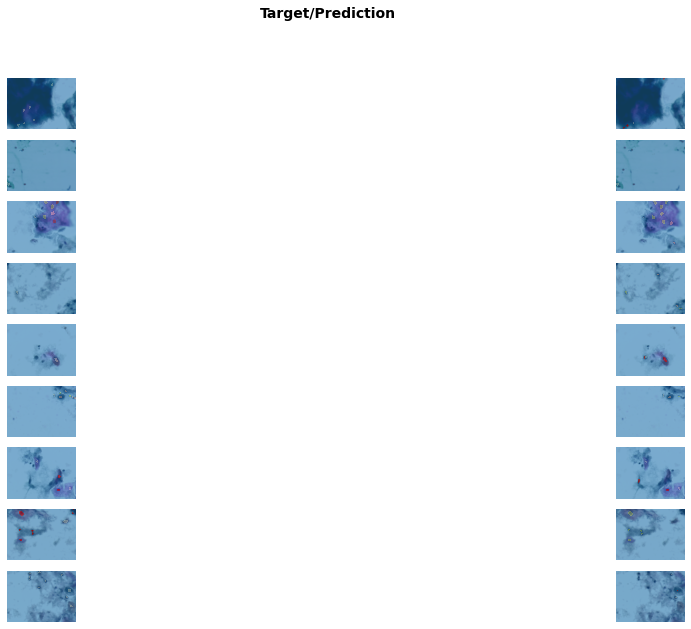

In [ ]:
get_learner(data, "best_model_600x800_stg2").show_results(figsize=(20, 10))

### Full Size

Training the model using the full size of the images. All the steps are identical to the 1/4 size training.

In [ ]:
size = src_size
bs = 4  # Adjust the batch size accordingly to the GPU VRAM capacity

transforms = [
    ToTensor(),
    IntToFloatTensor(),
    SegmentationAlbumentationsTransform(augmentations(size)),
]
print(size)

[1200 1600]


In [ ]:
data = src.dataloaders(bs=bs, after_item=transforms)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


SuggestedLRs(valley=8.31763736641733e-06)

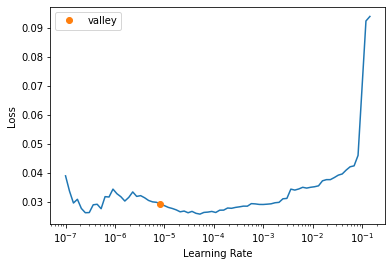

In [ ]:
get_learner(data, "best_model_600x800_stg2").lr_find()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with m_dsc value: 0.4616104145722171.


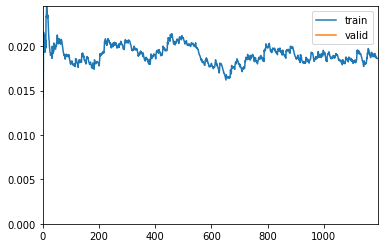

In [ ]:
lr = slice(1e-5)
wd = 1e-3

learn = get_learner(data, "best_model_600x800_stg2")
callbacks = [
    SaveModelCallback(
        monitor="m_dsc", fname="best_model_1200x1600_stg1", with_opt=True
    ),
    ShowGraphCallback(),
]

learn.fit_one_cycle(15, lr_max=lr, wd=wd, cbs=callbacks)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


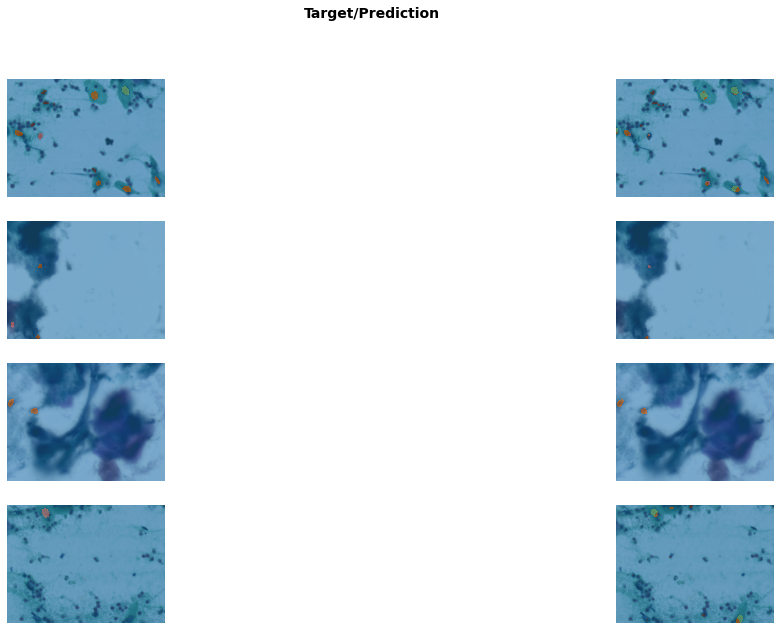

In [ ]:
get_learner(data, "best_model_1200x1600_stg1").show_results(
    figsize=(20, 10), vmax=len(codes)
)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


SuggestedLRs(valley=1.5848931980144698e-06)

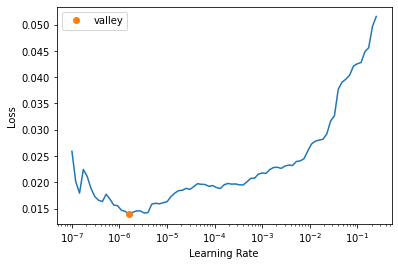

In [ ]:
get_learner(data, "best_model_1200x1600_stg1", True).lr_find()

100%|██████████| 83749/83749 [00:03<00:00, 21976.96KB/s]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with m_dsc value: 0.47223344894062763.


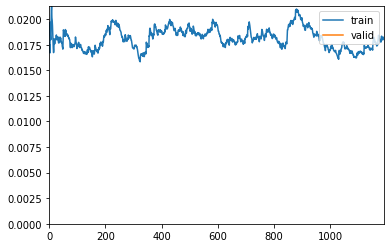

In [ ]:
lr = slice(1e-6, 1e-5)
wd = 1e-3
learn = get_learner(data, "best_model_1200x1600_stg1", True)
callbacks = [
    SaveModelCallback(
        monitor="m_dsc", fname="best_model_1200x1600_stg2", with_opt=True
    ),
    ShowGraphCallback(),
]

learn.fit_one_cycle(15, lr_max=lr, wd=wd, cbs=callbacks)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


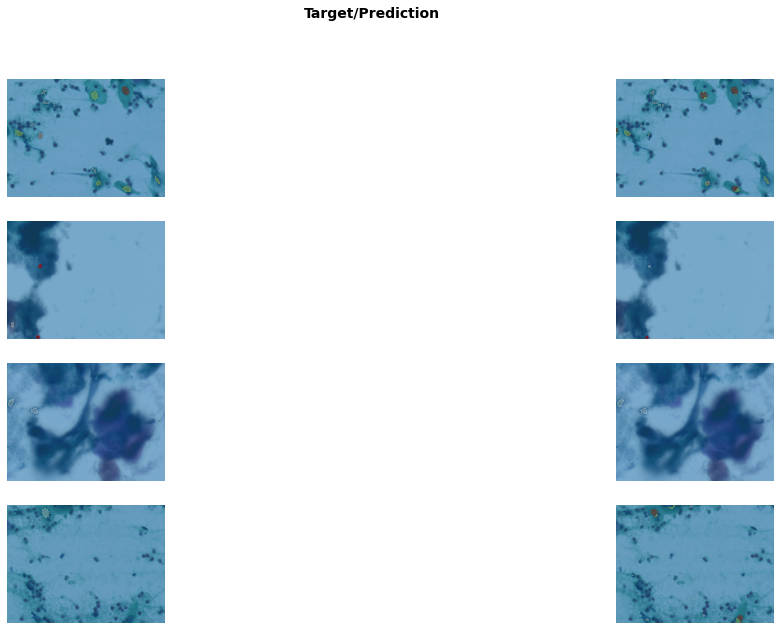

In [ ]:
get_learner(data, "best_model_1200x1600_stg2").show_results(figsize=(20, 10))

## Test

Run the metrics evaluations on the test set

### Evaluation on pixel-level

In [ ]:
from lapixdl.evaluation.evaluate import evaluate_segmentation

In [ ]:
def gt_mask_iterator_from_image_files(fnames, size):
    """Creates a iterator of numpy masks of a given size from a list of filenames."""
    for fname in fnames:
        yield np.array(PILMask.create(get_mask(fname)).resize((size[1], size[0])))


def pred_mask_iterator_from_image_files(fnames, size, predict):
    """Creates a iterator of predicted numpy masks of a given size from applying a predictor in a list of filenames."""
    for fname in fnames:
        res = predict(fname)
        yield np.array(res[0])


def evaluate_on_image_size(size):
    """Calculates the metrics for a given image size using the models trained in this notebook."""

    # Setup predictor
    transforms = [ImageResizer((size[0], size[1])), ToTensor(), IntToFloatTensor()]

    tfms = [[PILImage.create], [get_mask, PILMask.create, AddMaskCodes(codes)]]
    src = Datasets(test_image_files, tfms)
    test_dl = src.dataloaders(bs=1, after_item=transforms)

    learn = get_segmentation_learner(
        dls=test_dl,
        number_classes=len(codes),
        segmentation_type="Semantic Segmentation",
        architecture_name=architecture,
        backbone_name=backbone,
        metrics=metrics,
        splitter=hrnet_splitter,
        pretrained=True,
        loss_func=CrossEntropyLossFlat(axis=1),
    ).to_fp16()
    learn.path = path_models
    learn.load(f"best_model_{size[0]}x{size[1]}_stg2", with_opt=False)

    # Setups iterators to be compatible with the LapixDL library
    gt_masks = gt_mask_iterator_from_image_files(test_image_files, size)
    pred_masks = pred_mask_iterator_from_image_files(
        test_image_files, size, learn.predict
    )

    # Runs the evaluation using the LapixDL library
    eval = evaluate_segmentation(gt_masks, pred_masks, codes)
    eval.show_confusion_matrix()

    return eval

0 masks [00:00, ? masks/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


                     Average          background             anormal  \
Accuracy            0.993887            0.995437            0.997409   
Recall              0.352973  0.9985863260107417  0.6131005101515782   
Precision           0.377342            0.996818            0.580605   
Specificity         0.951713   0.616664404355576  0.9986128335705663   
F-Score             0.342066            0.997701            0.596411   
FPR                 0.048287            0.383336            0.001387   
IoU                 0.273410            0.995413            0.424918   
IoU w/o Background  0.170267                 NaN                 NaN   
TP                       NaN          1975632417             3818962   
TN                       NaN            10144579          1985892477   
FP                       NaN             6306150             2758590   
FN                       NaN             2796854             2409971   

                              saudavel        fora_de_foco  \
A

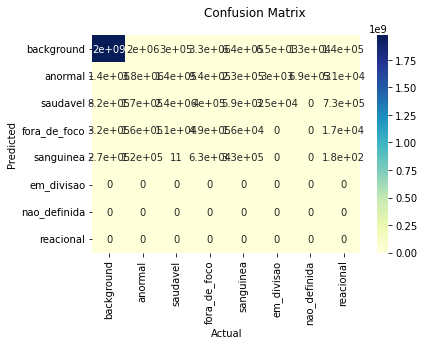

Average          background             anormal  \
Accuracy            0.993887            0.995437            0.997409   
Recall              0.352973  0.9985863260107417  0.6131005101515782   
Precision           0.377342            0.996818            0.580605   
Specificity         0.951713   0.616664404355576  0.9986128335705663   
F-Score             0.342066            0.997701            0.596411   
FPR                 0.048287            0.383336            0.001387   
IoU                 0.273410            0.995413            0.424918   
IoU w/o Background  0.170267                 NaN                 NaN   
TP                       NaN          1975632417             3818962   
TN                       NaN            10144579          1985892477   
FP                       NaN             6306150             2758590   
FN                       NaN             2796854             2409971   

                              saudavel        fora_de_foco  \
Accuracy                       0.99869            0.997409   
Recall              0.8423639160130766  0.0961497625273992   
Precision                     0.526514            0.486677   
Specificity         0.9989143515457273  0.9997378945731008   
F-Score                          0.648            0.160576   
FPR                           0.001086            0.000262   
IoU                            0.47929            0.087297   
IoU w/o Background                 NaN                 NaN   
TP                             2404842              494449   
TN                          1989862488          1989215991   
FP                             2162639              521521   
FN                              450031             4648039   

                             sanguinea  em_divisao nao_definida   reacional  
Accuracy                      0.999332    0.999978      0.99999    0.999529  
Recall              0.2735851760264971         0.0          0.0         0.0  
Precision                     0.428123         NaN          NaN         NaN  
Specificity         0.9997761352070117         1.0          1.0         1.0  
F-Score                       0.333837         0.0          0.0         0.0  
FPR                           0.000224         0.0          0.0         0.0  
IoU                           0.200363         0.0          0.0         0.0  
IoU w/o Background                 NaN         NaN          NaN         NaN  
TP                              334120           0            0           0  
TN                          1993212425  1994835610   1994860564  1993940656  
FP                              446310           0            0           0  
FN                              887145       44390        19436      939344

In [ ]:
# Evaluates on full size
eval_1200_1600 = evaluate_on_image_size((1200, 1600))
eval_1200_1600.to_dataframe()

0 masks [00:00, ? masks/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


                     Average          background             anormal  \
Accuracy            0.993601            0.995282            0.997126   
Recall              0.363836  0.9983099605390426  0.6044257884912063   
Precision           0.374519            0.996936             0.57398   
Specificity         0.955203  0.6449919820889249  0.9984676886538217   
F-Score             0.350869            0.997622            0.588809   
FPR                 0.044797            0.355008            0.001532   
IoU                 0.277809            0.995256            0.417243   
IoU w/o Background  0.175317                 NaN                 NaN   
TP                       NaN           493610809             1026098   
TN                       NaN             2756410           496260766   
FP                       NaN             1517147              761593   
FN                       NaN              835634              671543   

                              saudavel        fora_de_foco  \
A

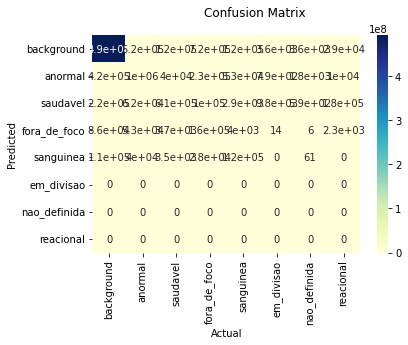

Average          background             anormal  \
Accuracy            0.993601            0.995282            0.997126   
Recall              0.363836  0.9983099605390426  0.6044257884912063   
Precision           0.374519            0.996936             0.57398   
Specificity         0.955203  0.6449919820889249  0.9984676886538217   
F-Score             0.350869            0.997622            0.588809   
FPR                 0.044797            0.355008            0.001532   
IoU                 0.277809            0.995256            0.417243   
IoU w/o Background  0.175317                 NaN                 NaN   
TP                       NaN           493610809             1026098   
TN                       NaN             2756410           496260766   
FP                       NaN             1517147              761593   
FN                       NaN              835634              671543   

                              saudavel        fora_de_foco  \
Accuracy                      0.998488            0.997517   
Recall              0.7837067157853141   0.127642627858761   
Precision                     0.512609             0.51733   
Specificity         0.9988260146261312  0.9997009432333079   
F-Score                        0.61981            0.204763   
FPR                           0.001174            0.000299   
IoU                           0.449076            0.114059   
IoU w/o Background                 NaN                 NaN   
TP                              614814              159455   
TN                           497350936           497321998   
FP                              584569              148772   
FN                              169681             1089775   

                             sanguinea em_divisao nao_definida  reacional  
Accuracy                      0.999282   0.999972     0.999988   0.999546  
Recall              0.3965993501641495        0.0          0.0        0.0  
Precision                     0.395295        NaN          NaN        NaN  
Specificity         0.9996399813891071        1.0          1.0        1.0  
F-Score                       0.395946        0.0          0.0        0.0  
FPR                            0.00036        0.0          0.0        0.0  
IoU                           0.246841        0.0          0.0        0.0  
IoU w/o Background                 NaN        NaN          NaN        NaN  
TP                              117301          0            0          0  
TN                           498244791  498705829    498713991  498493756  
FP                              179442          0            0          0  
FN                              178466      14171         6009     226244

In [ ]:
# Evaluates on 1/2 size
eval_600_800 = evaluate_on_image_size((600, 800))
eval_600_800.to_dataframe()

0 masks [00:00, ? masks/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


                     Average          background             anormal  \
Accuracy            0.993055            0.994786            0.996567   
Recall              0.318694  0.9983386569545831  0.5339703401348803   
Precision           0.356352            0.996407            0.538655   
Specificity         0.949269  0.5975385444968293  0.9982934309246797   
F-Score             0.320987            0.997372            0.536302   
FPR                 0.050731            0.402461            0.001707   
IoU                 0.253646            0.994758            0.366402   
IoU w/o Background  0.147773                 NaN                 NaN   
TP                       NaN           123369419              247507   
TN                       NaN              660448           124004494   
FP                       NaN              444833              211984   
FN                       NaN              205300              216015   

                              saudavel         fora_de_foco  \


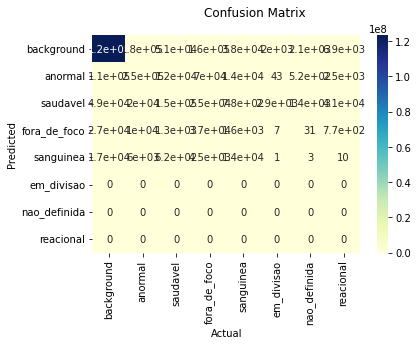

Average          background             anormal  \
Accuracy            0.993055            0.994786            0.996567   
Recall              0.318694  0.9983386569545831  0.5339703401348803   
Precision           0.356352            0.996407            0.538655   
Specificity         0.949269  0.5975385444968293  0.9982934309246797   
F-Score             0.320987            0.997372            0.536302   
FPR                 0.050731            0.402461            0.001707   
IoU                 0.253646            0.994758            0.366402   
IoU w/o Background  0.147773                 NaN                 NaN   
TP                       NaN           123369419              247507   
TN                       NaN              660448           124004494   
FP                       NaN              444833              211984   
FN                       NaN              205300              216015   

                              saudavel         fora_de_foco  \
Accuracy                      0.998357             0.997551   
Recall              0.6919723455573299  0.12345982098425484   
Precision                     0.510877              0.47488   
Specificity         0.9988767400953846    0.999669147195722   
F-Score                       0.587792             0.195971   
FPR                           0.001123             0.000331   
IoU                           0.416222              0.10863   
IoU w/o Background                 NaN                  NaN   
TP                              146029                37214   
TN                           124329156            124337423   
FP                              139811                41151   
FN                               65004               264212   

                              sanguinea em_divisao nao_definida  reacional  
Accuracy                       0.999334    0.99996     0.999967   0.999587  
Recall              0.20181204735173497        0.0          0.0        0.0  
Precision                      0.329996        NaN          NaN        NaN  
Specificity          0.9997738967973337        1.0          1.0        1.0  
F-Score                        0.250456        0.0          0.0        0.0  
FPR                            0.000226        0.0          0.0        0.0  
IoU                            0.143155        0.0          0.0        0.0  
IoU w/o Background                  NaN        NaN          NaN        NaN  
TP                                13877          0            0          0  
TN                            124583063  124674962    124675935  124628565  
FP                                28175          0            0          0  
FN                                54885       5038         4065      51435

In [ ]:
# Evaluates on 1/4 size
eval_300_400 = evaluate_on_image_size((300, 400))
eval_300_400.to_dataframe()

### Evaluation on instance-level

Instance level evaluation of the models using OpenCV Conected Components

In [ ]:
import json
from collections import defaultdict

import numpy.ma as ma
from lapixdl.evaluation.evaluate import calculate_bbox_iou, evaluate_detection
from lapixdl.evaluation.model import BBox

In [ ]:
# Path to instance-level annotations (COCO Format)
path_ann = path_dataset / "multiclass_coco_annotations"

In [ ]:
# Loads annotations, images and class names
with open(path_ann / "clean_simplified_test.json") as f:
    test_anns = json.load(f)

test_image_files = get_image_files(path_test_img)
test_anns_values = [img for img in test_anns["images"]]
cat_names = [cat["name"] for cat in test_anns["categories"]]

# Create index
imgToAnns = defaultdict(list)
annotations = defaultdict(list)
for ann in test_anns["annotations"]:
    imgToAnns[ann["image_id"]].append(ann)
    annotations[ann["id"]] = ann

print(cat_names)
print(codes)

: 

#### Utils

In [ ]:
# Mapping of predicted class ID to the GT class ID
pred_to_gt_class_map = {
    1: 0,  # anormal -> abnormal
    2: 3,  # saudavel -> normal
    3: 1,  # fora_de_foco -> out_of_focus
    4: 2,  # sanguinea -> blood
}


def mask_to_bboxes(mask_cats, mask_probs, nms_thresh, connectivity=8):
    """Converts a mask to a list of bounding boxes.

    Args:
          mask_cats: 2D mask array of the classes of each pixel.
          mask_probs: 3D mask array of #classes x height x width with the prediction score of each class for each pixel.
          nms_thresh: Non maximum supression threshold.
          connectivity: Connected Components connectivity. Defaults to 8.
    """
    bboxes = []

    # Connected Components
    bin_cls_mask = np.array(mask_cats != 0, dtype=np.int8)
    connected_components = cv2.connectedComponentsWithStats(
        bin_cls_mask, connectivity, cv2.CV_32S
    )
    (numLabels, labels, stats, centroids) = connected_components

    for i in range(1, numLabels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]

        if (
            h > 20 and w > 20
        ):  # Filter out bboxes with less than 20px for width or height
            # Instance mask
            componentMask = (labels != i).astype("uint8")

            # Identifies the predicted class for the bounding box as the most common pixel class under the instance mask
            flat_clss = filter(
                lambda p: p is not None and p != 0,
                ma.masked_array(mask_cats, mask=componentMask).flatten().tolist(),
            )
            cls_idx = Counter(flat_clss).most_common(1)[0][0]

            # If the most common class is the background, discards it
            if cls_idx not in pred_to_gt_class_map.keys():
                continue

            gt_class = pred_to_gt_class_map[cls_idx]
            prob_cls_mask = mask_probs[cls_idx]

            # Calculates the prediction score of the bounding box as the
            # mean of the scores for the predicted class under the mask of the instance
            predict_score = ma.masked_array(prob_cls_mask, mask=componentMask).mean()
            bboxes.append(BBox(x, y, w, h, gt_class, predict_score))

    return nms(bboxes, nms_thresh)


def nms(bboxes, thresh):
    """Applies the Non Maximum Supression algorithm in a list of bounding boxes"""
    ious = np.zeros((len(bboxes), len(bboxes)), float)

    for i, bbox_a in enumerate(bboxes):
        for j, bbox_b in enumerate(bboxes):
            ious[i, j] = calculate_bbox_iou(bbox_a, bbox_b) if i != j else 1

    return [
        bbox
        for i, bbox in enumerate(bboxes)
        if is_max_score_bbox(bboxes, ious, i, thresh)
    ]


def is_max_score_bbox(bboxes, ious, idx, thresh):
    """Identifies the bounding box with the greater score"""
    bbox = bboxes[idx]
    bbox_ious = ious[idx, :]
    bboxes_ious_above_thresh_scores = [
        bboxes[i].score
        for i, bbox_iou in enumerate(bbox_ious)
        if i != idx and bbox_iou > thresh
    ]
    return (
        bbox.score >= np.max(bboxes_ious_above_thresh_scores)
        if len(bboxes_ious_above_thresh_scores) > 0
        else True
    )


def resize_bbox(bbox, proportion):
    """Resizes a bounding box accordingly to a proportion"""
    x, y, w, h = bbox
    return [x * proportion[1], y * proportion[0], w * proportion[1], h * proportion[0]]


def evaluate_as_detection_on_image_size(size, score_thresh=0.5, nms_thresh=0.7):
    """Calculates the metrics for a given image size using the models trained in this notebook."""

    # Setup predictor
    transforms = [ImageResizer((size[0], size[1])), ToTensor(), IntToFloatTensor()]
    tfms = [
        [PILImage.create],
        [get_mask, read_mask_and_simplify_normal_nuclei, AddMaskCodes(codes)],
    ]
    src = Datasets(test_image_files, tfms)
    test_dl = src.dataloaders(bs=1, after_item=transforms)
    learn = get_learner(test_dl, f"best_model_{size[0]}x{size[1]}_stg2")

    # Gets GT and predicted bounding boxes from the masks
    all_gt_bboxes = []
    all_pred_bboxes = []
    for gt_img in test_anns_values:
        file_name = gt_img["file_name"]
        img_f = path_img / "test" / file_name

        # Gets instance-level annotations for the image
        coco_img = [f for f in test_anns_values if f["file_name"] == file_name][0]
        original_img_size = (float(coco_img["height"]), float(coco_img["width"]))
        resize_proportion = (
            size[0] / original_img_size[0],
            size[1] / original_img_size[1],
        )
        test_ann_ids = imgToAnns[coco_img["id"]]

        gt_anns = annotations[test_ann_ids]

        # Bounding boxes from GT
        gt_bboxes = []
        for idx, gt_ann in enumerate(gt_anns):
            x, y, w, h = resize_bbox(gt_ann["bbox"], resize_proportion)
            gt_bboxes.append(
                BBox(int(x), int(y), int(w), int(h), gt_ann["category_id"])
            )

        # Predicted bounding boxes
        cat, tensor, probs = learn.predict(img_f)
        pred_bboxes = mask_to_bboxes(cat, probs, nms_thresh)

        pred_bboxes = [bbox for bbox in pred_bboxes if bbox.score >= score_thresh]

        all_gt_bboxes.append(gt_bboxes)
        all_pred_bboxes.append(pred_bboxes)

    # Evaluates using the LapixDL library
    eval = evaluate_detection(all_gt_bboxes, all_pred_bboxes, cat_names)
    eval.show_confusion_matrix()

    return eval

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
['abnormal', 'out_of_focus', 'blood', 'normal']
['background' 'anormal' 'saudavel' 'fora_de_foco' 'sanguinea' 'em_divisao'
 'nao_definida' 'reacional']


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


0 samples [00:00, ? samples/s]

                             Average             abnormal  \
Accuracy                    0.288088             0.354078   
Recall                      0.371788  0.44702380952380955   
Precision                   0.567877             0.630034   
F-Score                     0.394383             0.522981   
IoU                         0.107166             0.244744   
TP                               NaN                  751   
FP                               NaN                  441   
FN                               NaN                  929   
TN                               NaN                  NaN   
Average Precision                NaN             0.361262   
11-point Average Precision       NaN             0.379062   

                                   out_of_focus               blood  \
Accuracy                               0.022031            0.154616   
Recall                      0.02239213544511196  0.2077727952167414   
Precision                              0.577465       

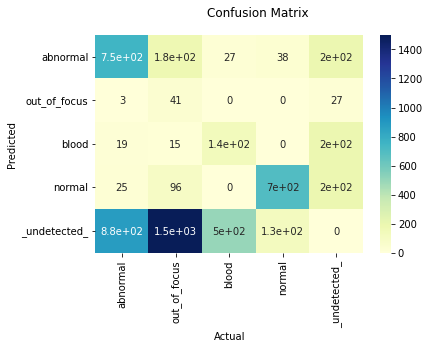

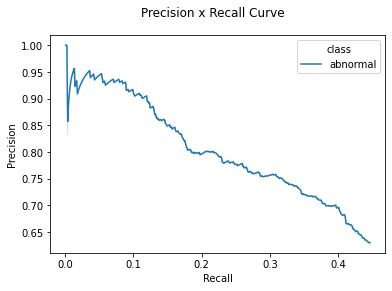

Average             abnormal  \
Accuracy                    0.288088             0.354078   
Recall                      0.371788  0.44702380952380955   
Precision                   0.567877             0.630034   
F-Score                     0.394383             0.522981   
IoU                         0.107166             0.244744   
TP                               NaN                  751   
FP                               NaN                  441   
FN                               NaN                  929   
TN                               NaN                  NaN   
Average Precision                NaN             0.361262   
11-point Average Precision       NaN             0.379062   

                                   out_of_focus               blood  \
Accuracy                               0.022031            0.154616   
Recall                      0.02239213544511196  0.2077727952167414   
Precision                              0.577465            0.376694   
F-Score                                0.043113            0.267823   
IoU                                    0.015409            0.048896   
TP                                           41                 139   
FP                                           30                 230   
FN                                         1790                 530   
TN                                          NaN                 NaN   
Average Precision                      0.014138            0.084791   
11-point Average Precision             0.090909             0.11216   

                                        normal  
Accuracy                              0.591871  
Recall                      0.8099652375434531  
Precision                             0.687316  
F-Score                               0.743617  
IoU                                   0.119616  
TP                                         699  
FP                                         318  
FN                                         164  
TN                                         NaN  
Average Precision                     0.739048  
11-point Average Precision            0.741094

In [ ]:
# Evaluates on full size
eval_1200_1600 = evaluate_as_detection_on_image_size(
    (1200, 1600), score_thresh=0.5, nms_thresh=0.7
)
eval_1200_1600.by_class[0].show_precision_recall_curve()
eval_1200_1600.to_dataframe()